In [1]:
%run process_3DG_science_2018.py

In [2]:
import pandas as pd
dest_file = '../../data/processed_data.hdf5'
a = pd.read_hdf(dest_file,where='Cell == 1')
a['Replicate'].unique()

array([0, 1, 2])

In [26]:
import pandas as pd
import numpy as np
import os

In [27]:
data_dir = '../../data/tan_single-cell_2018/Supp_GSM3271347_GM12878_Cell_1/'
files = os.listdir(data_dir)
files.sort()
for file in files: 
    if '.clean.con' in file:
        print(file) 


GSM3271347_gm12878_01.clean.con.txt.gz


In [28]:
def load_contacts(filepath):
    '''
    Assumes "two columns of 'chromosome,coordinate,haplotype' separated by a tab," 
    as described at https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM3271347
    '''

    # Load the data
    con_df = pd.read_csv(
        filepath,
        header=None,
        sep='\t',
        names=['Loc0','Loc1']
    )

    # Remove rows with NaN/missing values.
    con_df.dropna(
        axis='index',
        inplace=True,
        ignore_index=True
    )

    # Split the data separated by commas within each column.
    for i in range(2):
        con_df[[f'Chrom{i}',f'Genomic Index{i}',f'Haplotype{i}']] = con_df[f'Loc{i}'].str.split(',',expand=True)

    # Remove the unprocessed columns. 
    con_df.drop(columns=['Loc0','Loc1'],inplace=True)

    # Standardize the datatypes in each column.
    con_df = con_df.astype({'Chrom0':str,'Genomic Index0':np.int64,'Haplotype0':str,'Chrom1':str,'Genomic Index1':np.int64,'Haplotype1':str})

    # Remove duplicated lines, if present. 
    con_df.drop_duplicates(inplace=True,keep='first',ignore_index=True)

    return con_df

In [29]:
def validate_con_df(con_df): 
    
    for i in range(2): 

        # The haplotype columns should only contain ['.','0','1'] as options.
        uniq = con_df[f'Haplotype{i}'].unique()
        assert len(uniq) <= 3, f'Too many options in the Haplotype{i} column!'
        for k in uniq: 
            assert k in ['.','0','1'], f"Haplotype{i} contains invalid option {k}. Valid choices are '.', '0', or '1'"
    

In [70]:
def clean_con_df(con_df):
    '''
    For easier data analysis later, want the index
    at 'Genomic Index0' <= 'Genomic Index1' everywhere. 
    We also want these values to increase monotonically, 
    with higher weight on 'Genomic Index0'

    NOTE: This assumes that the index is 0,1,2,...,len(con_df)
    '''

    # Ensure index0 <= index1 in all rows
    idx = np.where(con_df['Genomic Index0'] > con_df['Genomic Index1'])[0]
    if len(idx) > 0:
        old = ['Chrom0','Genomic Index0','Haplotype0','Chrom1','Genomic Index1','Haplotype1']
        new = ['Chrom1','Genomic Index1','Haplotype1','Chrom0','Genomic Index0','Haplotype0']
        con_df.loc[idx,old] = con_df.loc[idx,new].values
        del old, new
    
    # Sort the values 
    con_df.sort_values(
        by=['Genomic Index0','Genomic Index1'],
        axis='index',
        inplace=True,
        ignore_index=True
    )
    

In [71]:
con_df = load_contacts(data_dir+'GSM3271347_gm12878_01.clean.con.txt.gz')
clean_con_df(con_df)
#clean_con_df(con_df) 

In [72]:
(con_df['Genomic Index0'] > con_df['Genomic Index1']).sum()

0

In [60]:
con_df.loc[idx,['Genomic Index0']]

,Genomic Index0
0,756402
1,757502
2,815689
3,818233
4,830604
...,...
657372,155175996
657373,155181600
657374,155184780
657375,155191595


In [55]:
idx = np.where(con_df['Genomic Index0'] < con_df['Genomic Index1'])
con_df.loc[idx]

,Chrom0,Genomic Index0,Haplotype0,Chrom1,Genomic Index1,Haplotype1
0,1,756402,.,1,1095166,.
1,1,757502,.,1,1218675,.
2,1,815689,.,1,1186166,.
3,1,818233,.,1,862021,.
4,1,830604,.,1,835996,.
...,...,...,...,...,...,...
657372,X,155175996,.,X,155195641,.
657373,X,155181600,.,X,155183465,.
657374,X,155184780,.,X,155185826,.
657375,X,155191595,.,X,155200662,.


In [40]:
len(np.where(con_df['Genomic Index0'] == con_df['Genomic Index1'])[0])

0

In [88]:
insert_metadata(con_df)

In [89]:
con_df

,Organism,Cell Type,Cell,Chrom0,Genomic Index0,Haplotype0,Chrom1,Genomic Index1,Haplotype1
0,Human,GM,1,1,756402,.,1,1095166,.
1,Human,GM,1,1,757502,.,1,1218675,.
2,Human,GM,1,1,815689,.,1,1186166,.
3,Human,GM,1,1,818233,.,1,862021,.
4,Human,GM,1,1,830604,.,1,835996,.
...,...,...,...,...,...,...,...,...,...
657372,Human,GM,1,X,155175996,.,X,155195641,.
657373,Human,GM,1,X,155181600,.,X,155183465,.
657374,Human,GM,1,X,155184780,.,X,155185826,.
657375,Human,GM,1,X,155191595,.,X,155200662,.


In [1]:
%run process_3DG_science_2018.py

KeyboardInterrupt: 

In [13]:
a = pd.read_hdf('../../data/processed_data.hdf5',key='scHi-C')

KeyError: 'No object named scHi-C in the file'

### Developing function to identify uninterrupted regions long enough for use in the diffusion model 

In [1]:
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import h5py
import os 
from process_raw_data import save_to_hdf5

def already_processed(filepath,organism,cell_type,cell_number,replicate_number):

    if not os.path.exists(filepath):
        # The file doesn't even exist, so it cannot contain the inquiried data.
        return False

    # Check if the relevant key is in the file. 
    with h5py.File(filepath, 'r') as f:
        if 'valid_start' not in f.keys():
            # No scHi-C data is contained, so the file cannot contain the
            # inquired data. 
            return False 
    
    # Load the data with the stated qualities if it's present. 
    temp = pd.read_hdf(
        filepath,
        key='valid_start',
        where=[
            f"Organism == {organism}",
            f"Cell_Type == {cell_type}",
            f"Cell == {cell_number}",
            f"Replicate == {replicate_number}"
        ],
        columns=['Bead_Index']
    )
    if len(temp) == 0:
        return False
    return True 

def find_valid_starts(filepath,resolution,required_length,organism,cell_type,cell_number,replicate_number):
    '''
    filepath: The hdf5 file containing all processed data. 
    resolution: Resolution of the 3D models (in bp) 
    required_length: How many uninterrupted beads are required? 

    This function assumes that the filepath is valid and already 
    contains the relevant 3D structural data.
    '''

    # Load the coordinates
    coord_df = pd.read_hdf(
        filepath,
        key='Coordinates',
        where=[
            f"Organism == {organism}",
            f"Cell_Type == {cell_type}",
            f"Cell == {cell_number}",
            f"Replicate == {replicate_number}"
        ],
        columns=['Genomic_Index']
    )

    # Find the genomic separation between monomers separated by (required_length-1)
    sep1 = required_length - 1
    sep = coord_df['Genomic_Index'][sep1:].values - coord_df['Genomic_Index'][:-sep1].values
    valid_starts = np.where( sep == (sep1 * resolution) )[0]
    return valid_starts

def get_unique_chroms(filepath,key='Coordinates'): 
    '''
    Given an HDF5 file at filepath, return all unique chromosomes 
    with 3D structures. Unique identifiers are: Organism, cell type, 
    cell number, replicate number, chromosome, and lineage (mat/pat). 
    '''

    # Load the columns containing the identifier information. 
    chromid_df = pd.read_hdf(
        filepath, 
        key=key,
        columns=['Organism','Cell_Type','Cell','Replicate','Lineage','Chromosome']
    )

    # Drop_duplicates will reduce the chromid_df DataFrame to its unique rows. 
    return chromid_df.drop_duplicates(ignore_index=True)

def drop_preprocessed_chroms(chromid_df,filepath):
    '''
    Given a set of chromosomes, check which have already been processed
    for their valid start positions. Remove those from the DataFrame to 
    avoid reprocessing them. 
    '''
    
    # Check if the relevant key is in the file (i.e. if any lengths have been
    # processed at all) 
    with h5py.File(filepath, 'r') as f:
        if 'permitted_length' not in f.keys():
            # No scHi-C data is contained, so the file cannot contain the
            # inquired data. 
            f.close()
            return

    # Load the unique identifiers for permitted lengths already preprocessed. 
    perlen_df = get_unique_chroms(filepath,'permitted_length')
    
    # Compare the two DataFrames to obtain an index of rows to keep
    idx = np.where((chromid_df.merge(perlen_df,how='left',indicator=True)['_merge'] != 'left_only'))[0]
    
    # Keep the rows that appear in the inquired DataFrame; drop others. Reset the index, as well. 
    if len(idx) > 0:
        chromid_df.drop(idx,axis='index',inplace=True)
        chromid_df.reset_index(drop=True, inplace=True)

    # chromid_df was modified inplace, so no need to return anything. 

def load_genomic_indices(filepath,organism,cell_type,cell_number,chromosome,lineage,replicate_number):
    '''
    Load the genomic indices for monomers with known 3D positions in a specific chromsome 
    from a specific replicate from a specific experiment. 

    The function assumes that the smallest genomic separation between known monomer positions 
    corresponds to the the resolution and returns that value. 
    '''

    genomic_index = pd.read_hdf(
        filepath,
        key='Coordinates',
        where=[
            f"Organism == {organism}",
            f"Cell_Type == {cell_type}",
            f"Cell == {cell_number}",
            f"Chromosome == '{chromosome}'",
            f"Lineage == {lineage}",
            f"Replicate == {replicate_number}"
        ],
        columns=['Genomic_Index']
    )['Genomic_Index'].values

    #resolution = ( genomic_index[1:] - genomic_index[:-1] ).min()
    return genomic_index#, resolution 

def find_permitted_lengths(filepath,organism,cell_type,cell_number,chromosome,lineage,replicate_number):
    '''
    filepath: The hdf5 file containing all processed data. 
    resolution: Resolution of the 3D models (in bp) 
    required_length: How many uninterrupted beads are required? 

    This function assumes that the filepath is valid and already 
    contains the relevant 3D structural data.
    '''

    # Load the genomic indices corresponding to each monomer in the 3D structure of this chromosome
    genomic_index = load_genomic_indices(filepath,organism,cell_type,cell_number,chromosome,
                                                     lineage,replicate_number)

    # Find the genomic separation between neighboring monomers. 
    sep = genomic_index[1:] - genomic_index[:-1]

    # The minimum value should correspond to the resolution. 
    resolution = sep.min() 

    # We are only interested in whether or not there are skipped monomers between neighboring, 
    # known monomers, so make this boolean (True/1 == nearest neighbors, False/0 == bead was skipped). 
    # Make it a pd Series object to simplify manipulation. 
    sep = pd.Series(sep == resolution)

    # We are interested in the number of beads you can travel FORWARD from any selected monomer
    # before arriving at a monomer that was removed during the Dip-C cleaning process.
    # SO, reverse the index of sep. 
    sep = sep.reindex(index=sep.index[::-1])

    # Cumulative sum provides the number of nearest neighbor positions identified thus far. 
    perlen = sep.cumsum()

    # Subtract the values associated with positions where a monomer is missing to reset the 
    # count of 'number of monomers you can traverse from here' to 0. In effect, this 
    # restarts the count each time a monomer is skipped in the 3D data. 
    perlen-= sep.cumsum().where(~sep).ffill().fillna(0)

    # Set the index back to its original location, realigning the data with bead indices. 
    perlen = perlen.reindex(index=perlen.index[::-1]).astype(np.int64)

    # Place the series object in a DataFrame, since that's how we're saving data in this project.
    perlen_df = pd.DataFrame()
    perlen_df['permitted_length'] = perlen

    # Finally, insert the metadata needed to search the larger structure when loading from the HDF5 file. 
    perlen_df.insert(loc=0,column='Replicate',value=replicate_number)
    perlen_df.insert(loc=0,column='Lineage',value=lineage)
    perlen_df.insert(loc=0,column='Chromosome',value=chromosome)
    perlen_df.insert(loc=0,column='Cell',value=cell_number)
    perlen_df.insert(loc=0,column='Cell_Type',value=cell_type)
    perlen_df.insert(loc=0,column='Organism',value=organism)

    return perlen_df

def find_all_permitted_lengths(filepath):
    '''
    Given an HDF5 file containing 3D conformations, get all valid starting positions 
    for all 3D structures contained in that file. 
    '''

    # Get the set of unique chromosomes to be analyzed. 
    chromid_df = get_unique_chroms(filepath)

    # Remove any rows whose valid starts have already been processed
    drop_preprocessed_chroms(chromid_df,filepath) 
 
    # This will ensure that identifiers are sent to find_permitted_lenghts in the proper order
    identifiers = ['Organism','Cell_Type','Cell','Chromosome','Lineage','Replicate']
    
    # Address ALL of these unique rows.
    nrows = len(chromid_df)
    for _,row in tqdm(chromid_df.iterrows(), desc = 'Processing Permitted Length', total = nrows):

        # Get the permitted lengths, formatted as needed for saving. 
        perlen_df = find_permitted_lengths(filepath,*row[identifiers].values)

        # Save the permitted lengths DataFrame to file
        save_to_hdf5(perlen_df,filepath)
    

    
    

In [ ]:
def load_genomic_indices(filepath,organism,cell_type,cell_number,chromosome,lineage,replicate_number):
    '''
    Load the genomic indices for monomers with known 3D positions in a specific chromsome 
    from a specific replicate from a specific experiment. 

    The function assumes that the smallest genomic separation between known monomer positions 
    corresponds to the the resolution and returns that value. 
    '''

    genomic_index = pd.read_hdf(
        filepath,
        key='Coordinates',
        where=[
            f"Organism == {organism}",
            f"Cell_Type == {cell_type}",
            f"Cell == {cell_number}",
            f"Chromosome == '{chromosome}'",
            f"Lineage == {lineage}",
            f"Replicate == {replicate_number}"
        ],
        columns=['Genomic_Index']
    )['Genomic_Index'].values

    return genomic_index

def load_many_genomic_indices(filepath,chromid_df):
    '''
    Load the genomic indices for monomers with known 3D positions in a specific chromsome 
    from a specific replicate from a specific experiment. 

    The function assumes that the smallest genomic separation between known monomer positions 
    corresponds to the the resolution and returns that value. 
    '''

    genomic_index = pd.read_hdf(
        filepath,
        key='Coordinates',
        where=[
            f"Organism in {chromid_df['Organism'].unique()}",
            f"Cell_Type in {chromid_df['Cell_Type'].unique()}",
            f"Cell in {chromid_df['Cell'].unique()}",
            f"Chromosome in {chromid_df['Chromosome'].unique()}",
            f"Lineage in {chromid_df['Lineage'].unique()}",
            f"Replicate in {chromid_df['Replicate'].unique()}",
        ],
        columns=['Organism','Cell_Type','Cell','Chromosome','Lineage','Replicate','Genomic_Index']
    )

    return genomic_index


def find_permitted_lengths(filepath,organism,cell_type,cell_number,chromosome,lineage,replicate_number,
                          genomic_index=None):
    '''
    filepath: The hdf5 file containing all processed data. 
    resolution: Resolution of the 3D models (in bp) 
    required_length: How many uninterrupted beads are required? 

    This function assumes that the filepath is valid and already 
    contains the relevant 3D structural data.
    '''

    # Load the genomic indices corresponding to each monomer in the 3D structure of this chromosome
    if genomic_index is None:
        genomic_index = load_genomic_indices(filepath,organism,cell_type,cell_number,chromosome,
                                                         lineage,replicate_number)
        
    # Find the genomic separation between neighboring monomers. 
    sep = genomic_index[1:] - genomic_index[:-1]

    # The minimum value should correspond to the resolution. 
    resolution = sep.min() 

    # We are only interested in whether or not there are skipped monomers between neighboring, 
    # known monomers, so make this boolean (True/1 == nearest neighbors, False/0 == bead was skipped). 
    # Make it a pd Series object to simplify manipulation. 
    sep = pd.Series(sep == resolution)

    # We are interested in the number of beads you can travel FORWARD from any selected monomer
    # before arriving at a monomer that was removed during the Dip-C cleaning process.
    # SO, reverse the index of sep. 
    sep = sep.reindex(index=sep.index[::-1])

    # Cumulative sum provides the number of nearest neighbor positions identified thus far. 
    perlen = sep.cumsum()

    # Subtract the values associated with positions where a monomer is missing to reset the 
    # count of 'number of monomers you can traverse from here' to 0. In effect, this 
    # restarts the count each time a monomer is skipped in the 3D data. 
    perlen-= sep.cumsum().where(~sep).ffill().fillna(0)

    # Set the index back to its original location, realigning the data with bead indices. 
    perlen = perlen.reindex(index=perlen.index[::-1]).astype(np.int64)

    # Place the series object in a DataFrame, since that's how we're saving data in this project.
    perlen_df = pd.DataFrame()
    perlen_df['permitted_length'] = perlen

    # Finally, insert the metadata needed to search the larger structure when loading from the HDF5 file. 
    perlen_df.insert(loc=0,column='Replicate',value=replicate_number)
    perlen_df.insert(loc=0,column='Lineage',value=lineage)
    perlen_df.insert(loc=0,column='Chromosome',value=chromosome)
    perlen_df.insert(loc=0,column='Cell',value=cell_number)
    perlen_df.insert(loc=0,column='Cell_Type',value=cell_type)
    perlen_df.insert(loc=0,column='Organism',value=organism)

    return perlen_df

def find_all_permitted_lengths(filepath,temp_filepath=None,simultaneous_index=True):
    '''
    Given an HDF5 file containing 3D conformations, get all valid starting positions 
    for all 3D structures contained in that file. 
    '''

    # Load all the relevant data! 
    

    # Remove any rows whose valid starts have already been processed
    drop_preprocessed_chroms(chromid_df,filepath) 

    # Load all of the relevant genomic indices simultaneously... this approach saves computation time
    # but requires significantly more memory. 
    if simultaneous_index:
        genomic_indices = load_many_genomic_indices(chromid_df)
    
    # This will ensure that identifiers are sent to find_permitted_lenghts in the proper order
    identifiers = ['Organism','Cell_Type','Cell','Chromosome','Lineage','Replicate']
    
    
    # Address ALL of these unique rows.
    nrows = len(chromid_df)
    parlen_dfs = []
    for _,row in tqdm(chromid_df.iterrows(), desc = 'Processing Permitted Length', total = nrows):

        parlen_dfs.append( find_permitted_lengths(filepath,*row[identifiers].values) )
        
        # Get the permitted lengths, formatted as needed for saving. 
        perlen_df = find_permitted_lengths(filepath,*row[identifiers].values)
        
        # Save the permitted lengths DataFrame to file
        save_to_hdf5(perlen_df,temp_filepath,compression_level=compression_level)

    if temp_filepath != filepath: 
        perlen_df = pd.read_hdf(temp_filepath,key='permitted_length')

In [7]:
find_all_permitted_lengths('../../data/processed_data.hdf5')

Processing Permitted Length:   0%|          | 0/2169 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:

def find_all_permitted_lengths(filepath):
    '''
    Given an HDF5 file containing 3D conformations, get all valid starting positions 
    for all 3D structures contained in that file. 
    '''

    # Get the set of unique chromosomes to be analyzed. 
    chromid_df = get_unique_chroms(filepath)

    # Remove any rows whose valid starts have already been processed
    drop_preprocessed_chroms(chromid_df,filepath) 
 
    # This will ensure that identifiers are sent to find_permitted_lenghts in the proper order
    identifiers = ['Organism','Cell_Type','Cell','Chromosome','Lineage','Replicate']
    
    # Address ALL of these unique rows.
    nrows = len(chromid_df)
    for _,row in tqdm(chromid_df.iterrows(), desc = 'Processing Permitted Length', total = nrows):

        # Get the permitted lengths, formatted as needed for saving. 
        perlen_df = find_permitted_lengths(filepath,*row[identifiers].values)

        # Save the permitted lengths DataFrame to file
        save_to_hdf5(perlen_df,filepath)

In [2]:
import time
filepath = '../../data/processed_data.hdf5'
t = time.time()
chromid_df = get_unique_chroms(filepath)
t-= time.time()
print(f'{-t}s')

39.67500400543213s


In [3]:
t = time.time()
drop_preprocessed_chroms(chromid_df,filepath) 
t-= time.time()
print(f'{-t}s')

0.17181134223937988s


In [5]:
def find_permitted_lengths(filepath,organism,cell_type,cell_number,chromosome,lineage,replicate_number):
    '''
    filepath: The hdf5 file containing all processed data. 
    resolution: Resolution of the 3D models (in bp) 
    required_length: How many uninterrupted beads are required? 

    This function assumes that the filepath is valid and already 
    contains the relevant 3D structural data.
    '''

    t = time.time()
    # Load the genomic indices corresponding to each monomer in the 3D structure of this chromosome
    genomic_index = load_genomic_indices(filepath,organism,cell_type,cell_number,chromosome,
                                                     lineage,replicate_number)
    t-= time.time()
    print(f'load_genomic_indices: {-t}s')
    
    # Find the genomic separation between neighboring monomers. 
    sep = genomic_index[1:] - genomic_index[:-1]

    # The minimum value should correspond to the resolution. 
    resolution = sep.min() 

    # We are only interested in whether or not there are skipped monomers between neighboring, 
    # known monomers, so make this boolean (True/1 == nearest neighbors, False/0 == bead was skipped). 
    # Make it a pd Series object to simplify manipulation. 
    sep = pd.Series(sep == resolution)

    # We are interested in the number of beads you can travel FORWARD from any selected monomer
    # before arriving at a monomer that was removed during the Dip-C cleaning process.
    # SO, reverse the index of sep. 
    sep = sep.reindex(index=sep.index[::-1])

    # Cumulative sum provides the number of nearest neighbor positions identified thus far. 
    perlen = sep.cumsum()

    # Subtract the values associated with positions where a monomer is missing to reset the 
    # count of 'number of monomers you can traverse from here' to 0. In effect, this 
    # restarts the count each time a monomer is skipped in the 3D data. 
    perlen-= sep.cumsum().where(~sep).ffill().fillna(0)

    # Set the index back to its original location, realigning the data with bead indices. 
    perlen = perlen.reindex(index=perlen.index[::-1]).astype(np.int64)

    # Place the series object in a DataFrame, since that's how we're saving data in this project.
    perlen_df = pd.DataFrame()
    perlen_df['permitted_length'] = perlen

    # Finally, insert the metadata needed to search the larger structure when loading from the HDF5 file. 
    perlen_df.insert(loc=0,column='Replicate',value=replicate_number)
    perlen_df.insert(loc=0,column='Lineage',value=lineage)
    perlen_df.insert(loc=0,column='Chromosome',value=chromosome)
    perlen_df.insert(loc=0,column='Cell',value=cell_number)
    perlen_df.insert(loc=0,column='Cell_Type',value=cell_type)
    perlen_df.insert(loc=0,column='Organism',value=organism)

    return perlen_df

In [6]:
nrows = len(chromid_df) 
identifiers = ['Organism','Cell_Type','Cell','Chromosome','Lineage','Replicate']
for _,row in tqdm(chromid_df.iterrows(), desc = 'Processing Permitted Length', total = nrows):

    # Get the permitted lengths, formatted as needed for saving. 
    t = time.time()
    perlen_df = find_permitted_lengths(filepath,*row[identifiers].values)
    t-= time.time()
    print(f'{-t}s')
    
    # Save the permitted lengths DataFrame to file
    t = time.time()
    #save_to_hdf5(perlen_df,filepath)
    t-= time.time()
    print(f'{-t}s')
    break
    

Processing Permitted Length:   0%|          | 0/2162 [00:00<?, ?it/s]

load_genomic_indices: 4.24481201171875s
4.249603748321533s
2.384185791015625e-07s


In [ ]:
note: 

imagen did something smart with ... 
zhuohan... ask about the dimensions of embedded data 

In [5]:
filepath = '../../data/processed_data.hdf5'
chromid_df = get_unique_chroms(filepath)

# Remove any rows whose valid starts have already been processed
drop_preprocessed_chroms(chromid_df,filepath) 


In [ ]:
chromid_df

In [ ]:
t = time.time()
data_test = pd.read_hdf(
    filepath,
    key='Coordinates',
    where=[
        f"Organism in {chromid_df['Organism'].unique()}",
        f"Cell_Type in {chromid_df['Cell_Type'].unique()}",
        f"Cell in {chromid_df['Cell'].unique()}",
        f"Chromosome in {chromid_df['Chromosome'].unique()}",
        f"Lineage in {chromid_df['Lineage'].unique()}",
        f"Replicate in {chromid_df['Replicate'].unique()}",
    ],
    columns=['Organism','Cell_Type','Cell','Chromosome','Lineage','Replicate','Genomic_Index']
)
t-= time.time() 

In [45]:
filepath = './test.hdf5'
chromid_df.to_hdf(
    filepath,
    key='layer1/layer2/layer3/',
    mode='a',
    append=True,
    index=False,
    format='table',
    data_columns=True,
    complevel=9
)


In [ ]:
key=key,                        # The key corresponds to the type of data being saved so that tables with different
                                        # column structures can be saved to the same file. 
        mode='a',                       # Append to existing data so that we can process cells one at a time without
        append=True,                    # running into memory issues. 
        index=False,                    # We don't care about the index from the DataFrame, so don't save it
        format='table',                 # Slower than the fixed format, but allows the data to be indexed upon loading
        data_columns=indexable_columns, # Which columns do we want to be indexable upon loading data from the HDF5 file? 
        complevel=compression_level     # Maximum data compression is 9; final file should use a value of 9 
    )


In [1]:
from process_raw_data import load_coords, process_coord_data
filepath = '../../data/tan_single-cell_2018/Supp_GSM3271347_GM12878_Cell_1/GSM3271347_rep2_gm12878_01.impute3.round4.clean.3dg.txt.gz'
coord_df = load_coords(filepath)
coord_df = process_coord_data(coord_df)

In [4]:
coord_df

,Lineage,Chromosome,Genomic Index,x,y,z
0,mat,1,760000,5.416942,-28.558234,-0.897106
1,mat,1,780000,4.640265,-27.566048,-0.400340
2,mat,1,800000,4.879129,-25.273661,0.264657
3,mat,1,820000,4.910836,-24.333975,-0.684009
4,mat,1,840000,4.826249,-20.710548,-2.482362
...,...,...,...,...,...,...
253716,pat,X,155040000,17.993318,28.084396,8.151358
253717,pat,X,155060000,17.667771,29.206659,8.166938
253718,pat,X,155080000,18.820752,29.632180,8.567538
253719,pat,X,155100000,20.270407,27.621826,8.148171


In [1]:
from process_raw_data import load_coords, process_coord_data
import numpy as np
import pandas as pd
import os 

In [2]:
def find_permitted_lengths(genomic_index):
    '''
    This function assumes that the filepath is valid and already 
    contains the relevant 3D structural data.
    '''

    # Find the genomic separation between neighboring monomers. 
    sep = genomic_index[1:] - genomic_index[:-1]

    # The minimum value should correspond to the resolution. 
    resolution = sep.min() 

    # We are only interested in whether or not there are skipped monomers between neighboring, 
    # known monomers, so make this boolean (True/1 == nearest neighbors, False/0 == bead was skipped). 
    # Make it a pd Series object to simplify manipulation. 
    sep = pd.Series(sep == resolution)

    # We are interested in the number of beads you can travel FORWARD from any selected monomer
    # before arriving at a monomer that was removed during the Dip-C cleaning process.
    # SO, reverse the index of sep. 
    sep = sep.reindex(index=sep.index[::-1])

    # Cumulative sum provides the number of nearest neighbor positions identified thus far. 
    perlen = sep.cumsum()

    # Subtract the values associated with positions where a monomer is missing to reset the 
    # count of 'number of monomers you can traverse from here' to 0. In effect, this 
    # restarts the count each time a monomer is skipped in the 3D data. 
    perlen-= sep.cumsum().where(~sep).ffill().fillna(0)

    # Set the index back to its original location, realigning the data with bead indices. 
    perlen = perlen.reindex(index=perlen.index[::-1]).astype(np.int64)

    # Pad the backend to account for the fact that len(sep) == len(genomic_index)-1
    perlen[len(perlen)] = 0 

    return perlen


In [3]:
def place_coord_lineages_sbs(coord_df):
    '''
    Rearrange coord_df with columns 
    ['Lineage','Chromosome','Genomic_Index','x','y','z']
    to have columns
    ['Chromosome','mat_x','mat_y','may_z','pat_z','pat_y','pat_z'].
    Pad coordinates with np.nan when genomic positions  are present in 
    one copy but not the other. 
    '''

    combined_dfs = {}
    sub_cols = ['Genomic_Index','x','y','z']
    for chrom in coord_df['Chromosome'].unique().tolist():

        # Get the subset of the main DataFrame corresponding to the maternal copy of this chromosome
        mat = coord_df[ (coord_df['Chromosome']==chrom) & (coord_df['Lineage']=='mat') ][sub_cols]
        mat.rename(columns={'x':'mat_x','y':'mat_y','z':'mat_z'},inplace=True)

        # Perform the same steps for the paternal chromosome
        pat = coord_df[ (coord_df['Chromosome']==chrom) & (coord_df['Lineage']=='pat') ][sub_cols]
        pat.rename(columns={'x':'pat_x','y':'pat_y','z':'pat_z'},inplace=True)

        # Merge the two matrices
        c = pd.merge(mat,pat,on='Genomic_Index') 

        if len(c) == 0:
            continue

        # JUST IN CASE, resort the genomic index. Pretty sure this line doesn't do anything though. 
        c.sort_values('Genomic_Index',ignore_index=True,inplace=True)

        # Find the number of consecutive monomer following each known monomer (i.e. those not
        # removed in the cleaning process) 
        c['Permitted_Lengths'] = find_permitted_lengths(c['Genomic_Index'].values)

        # Place the combined DataFrame in the dictionary being sent back 
        combined_dfs[chrom] = c
    
    return combined_dfs

        
        

In [128]:
import random 
import torch
class Dataset:

    def __init__(self,filepath):

        # Set filepath attribute
        self.filepath = filepath
        self.seg_len = None
        self.start_idxs = None 
        self.inner_idx = None
        self.epoch = 0

        # Get the DataFrame containing information 
        # that helps keep track of the data in each 
        # object associated with the datafile. 
        self._get_info_dfs()


    def _get_info_dfs(self):

        if os.path.exists(self.filepath): 
            # For now, just assume the file is 
            # properly formatted. 
            self._coord_info = pd.read_hdf(
                self.filepath,
                key='coord_info'
            )
        else: 
            # Need to initialize these objects.
            self._coord_info = pd.DataFrame(
                columns=[
                    'Accession',
                    'Organism',
                    'Cell_Type',
                    'Cell',
                    'Replicate',
                    'Chromosome',
                    'idx_min',
                    'idx_max'
                ]
            )

    def process_3dg_file(self,filepath,acc_number,organism,cell_type,
                         cell_number,replicate_number):
        
        # Check if this data has been processed before
        row = pd.DataFrame({
            'Accession':[acc_number],
            'Organism':[organism],
            'Cell_Type':[cell_type],
            'Cell':[cell_number],
            'Replicate':[replicate_number],
            'Chromosome':[''],
            'idx_min':[np.nan],
            'idx_max':[np.nan]
        })
        sub_cols = ['Accession','Organism','Cell_Type','Cell','Replicate']
        if len(self._coord_info) > 0:
            if ( self._coord_info[sub_cols].values == row[sub_cols].values ).all(1).any():
                # This file has already been processed
                return 

        # Load the file in its raw format. 
        coord_df = load_coords(filepath)

        # Process the data to obey the assumptions made in this class
        coord_df = process_coord_data(coord_df)

        # Place the maternal/paternal coordinates side-by-side in the same object 
        coord_dfs = place_coord_lineages_sbs(coord_df)

        # Update the info object. 
        rows = []
        end_idx = -1 if len(self._coord_info) == 0 else self._coord_info['idx_max'][len(self._coord_info)-1]
        for chrom,coord_df in coord_dfs.items():
            row['Chromosome'] = [chrom]
            row['idx_min'] = [end_idx + 1]
            end_idx+= len(coord_df) 
            row['idx_max'] = [end_idx]

            rows.append(row.copy())

        rows = pd.concat(rows,ignore_index=True)
        # Shift the index to the correct overall values prior to saving
        rows.index+= len(ds._coord_info) 

        # Save the info 
        indexable_columns = True
        rows.to_hdf(
            self.filepath,                  # The file where the data should be saved. 
            key='coord_info',               # The key corresponds to the type of data being saved so that tables with different
                                            # column structures can be saved to the same file. 
            mode='a',                       # Append to existing data so that we can process cells one at a time without
            append=True,                    # running into memory issues. 
            index=False,                    # We don't care about the index specific to the DataFrame, so don't save it
            format='table',                 # Slower than the fixed format, but allows the data to be indexed upon loading
            data_columns=indexable_columns, # Which columns do we want to be indexable upon loading data from the HDF5 file? 
            complevel=9                     # Maximum data compression is 9
        )

        # Add the each coord_df in coord_dfs to the save file
        coord_df = pd.concat(coord_dfs,ignore_index=True)
        # Shift the index to match the saved DataFrame
        coord_df.index+= rows['idx_min'].iloc[0] 
        
        # Save to file
        indexable_columns = ['Genomic_Index','index']
        coord_df.to_hdf(
            self.filepath,                  # The file where the data should be saved. 
            key='Coordinates',              # The key corresponds to the type of data being saved so that tables with different
                                            # column structures can be saved to the same file. 
            mode='a',                       # Append to existing data so that we can process cells one at a time without
            append=True,                    # running into memory issues. 
            index=True,                     # We don't care about the index specific to the DataFrame, so don't save it
            format='table',                 # Slower than the fixed format, but allows the data to be indexed upon loading
            data_columns=indexable_columns, # Which columns do we want to be indexable upon loading data from the HDF5 file? 
            complevel=9                     # Maximum data compression is 9
        )

        # Update the info object
        self._get_info_dfs()

    def _get_valid_starts(self,segment_length,allow_overlap=False): 
        '''
        Find all indices where, including that bead, there are segment_length
        sequential beads in a row (i.e. not removed during Dip-C clean process)

        If allow_overlap is set to False, the indices returned will represent
        the starting points for non-overlapping regions only
        '''

        # Load the valid_lengths column. 
        vl = pd.read_hdf(
            self.filepath,
            key='Coordinates',
            columns=['Permitted_Lengths']
        )['Permitted_Lengths']

        # If overlapping regions are fine, simply need segments long enough
        # to satisfy the following 
        if allow_overlap:
            return vl[vl > segment_length-2].index

        # A monomer at the extreme end of one segment can appear as the start of the next 
        # segment per this setup 
        perlens_for_no_overlap = np.arange(segment_length-1,vl.max()+.5,segment_length-1)
        perlens_for_no_overlap = perlens_for_no_overlap.reshape(1,len(perlens_for_no_overlap))

        vl = vl.values.reshape(len(vl),1)
        return np.where( (vl == perlens_for_no_overlap).any(1) )[0]

    def set_valid_starts(self,segment_length,allow_overlap=False):

        self.seg_len = segment_length 
        self.start_idxs = self._get_valid_starts(segment_length,allow_overlap)

    ################
    # Data loading 

    def reset_index(self):

        self.epoch+=1
        self.inner_idx = 0
        if self.shuffle: 
            random.shuffle(self.data_index)
            
    def prepare_DataLoader(self,segment_length,batch_size,shuffle=True,
                           allow_overlap=False,two_channels=False,try_GPU=True):
        '''
        segment_length: The number of monomers relevant to the distance maps 
        batch_size: Number of configurations per batch 
        shuffle: Should the sample indices be shuffled before each epoch? 
        allow_overlap: Can the dataset include overlapping regions (True), 
                       or should they all be fully independent (False)? 
        two_channels: Does the data include the maternal & paternal structures
                        in the same sample (two channels of the image)? Otherwise, 
                        returns one or the other. 
        '''

        try:
            assert try_GPU
            self.device = torch.empty(1).cuda().device
        except:
            self.device = torch.empty(1).device

        self.two_channels = two_channels
        self.epoch = 0
        
        # Get the valid starts
        self.set_valid_starts(segment_length,allow_overlap)

        # Set the batch size
        self.batch_size = batch_size 

        # This will be used when computing euclidean distances
        self.triu_indices = torch.triu_indices(segment_length,segment_length,1)

        # Set the sample indices
        if two_channels: 
            self.data_index = [ (i,['mat_x','mat_y','mat_z','pat_x','pat_y','pat_z']) for i in self.start_idxs]
            ############
            # Must define a sample loader if we follow this approach
            ###############
        else: 
            self.data_index = [ (i,['mat_x','mat_y','mat_z']) for i in self.start_idxs]
            self.data_index.extend( [ (i,['pat_x','pat_y','pat_z']) for i in self.start_idxs] )

        self.shuffle = shuffle
        self.reset_index()

        # Initialize the coord batch object
        self.coord_batch = torch.empty(batch_size,self.seg_len,3*(1+int(two_channels)),dtype=torch.double,device=self.device)

        # Initialize the distance batch
        self.dist_batch = torch.empty(batch_size,1+int(two_channels),self.seg_len,self.seg_len,dtype=torch.float,device=self.device)


    def update_coord_batch(self):
        assert self.seg_len is not None, "Must run prepare_DataLoader before loading data!"
        
        for i in range(self.batch_size):
            
            start,cols = self.data_index[self.inner_idx]
            
            self.coord_batch[i,...] = torch.from_numpy(
                pd.read_hdf(
                    self.filepath,
                    key='Coordinates',
                    start=start,
                    stop=start+self.seg_len,
                    columns=cols
                ).values
            ).to(self.device,self.coord_batch.dtype)

            self.inner_idx+= 1
            if self.inner_idx >= len(self.data_index):
                self.reset_index()

    def dist_to_norm(self,dists):

        raise Exception('Must still implement')
        
    def update_dist_maps(self):

        i,j = self.triu_indices

        if self.two_channels:
            raise Exception('Two channels not yet implemented in update_dist_maps')
        else:
            self.dist_batch[:,i,j-1] = self.dist_to_norm(torch.cdist(self.coord_batch,self.coord_batch)[:,i,j])
            self.dist_batch[:,j-1,i] = self.dist_batch[:,i,j-1]
        
        
        

In [129]:
data_dir = '../../data/tan_single-cell_2018/'
filepath = '../../data/processed_data.hdf5'

# This extracts cell type, cell number information from data folders.
def parse_folder_science2018(folder):

    f = folder.split('_')
    cell_type = f[-3]
    cell_number = f[-1]

    if '-' in cell_number: 
        cell_number = cell_number.split('-')[0]

    return cell_type, int(cell_number)

# This extracts replicate information from filenames. 
def parse_fname_science2018(fname):
    '''
    returns (<desired file>,<replicate_number>)
    '''

    if 'impute3.round4.clean.3dg' not in file:
        # We don't care about this file
        return False, -1

    if 'rep1' in file:
        replicate_number = 1
    elif 'rep2' in file:
        replicate_number = 2
    else:
        replicate_number = 0

    return True, replicate_number 


acc_number = 'GSE117876'
organism = 'Human'
ds = Dataset(filepath)
folders = os.listdir(data_dir)
folders.sort()
for folder in folders:

    # Collect some metadata from the folder name
    cell_type, cell_number = parse_folder_science2018(folder) 
    
    # Locate all files that we wish to place in the HDF5 file
    # to be used by the dataloader function.
    subfolder = data_dir + folder
    filenames = os.listdir(subfolder)
    filenames.sort() # Causes replicas to show up in the correct order
    for file in filenames:
        relevant_file, replicate_number = parse_fname_science2018(file)
        if not relevant_file: 
            # This isn't one of the 3d files we aim to process. 
            continue

        raw_file = subfolder + '/' + file
        ds.process_3dg_file(raw_file,acc_number,organism,cell_type,
                            cell_number,replicate_number)

In [159]:
import time

max_iters = 1000
batch_size = 64
ds.prepare_DataLoader(segment_length,batch_size,shuffle=True,
                   allow_overlap=False,two_channels=False,try_GPU=True)
ts = []
while ds.epoch == 1 and ds.inner_idx < max_iters:
    t = time.time()
    ds.update_coord_batch()
    t-= time.time()
    ts.append(-t) 

In [160]:
np.mean(ts)

0.4725840836763382

In [161]:
np.std(ts) 

0.0012567070520553669

In [162]:
np.min(ts)

0.4701519012451172

In [163]:
np.max(ts)

0.47472572326660156

In [155]:
for _,row in ds._coord_info.iterrows():
    break

In [157]:
row['idx_min']

0

In [1]:
import torch
import matplotlib.pyplot as plt

In [2]:
mean_dist_fp = '../../data/mean_dists.pt'
mean_sq_dist_fp='../../data/squares.pt'

In [3]:
means = torch.load(mean_dist_fp)
mean_sqs = torch.load(mean_sq_dist_fp)

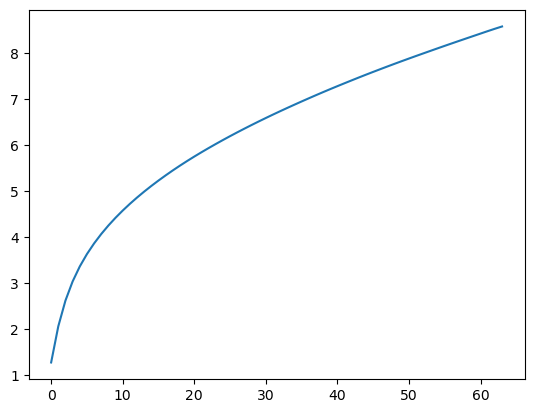

In [4]:
plt.plot(means)

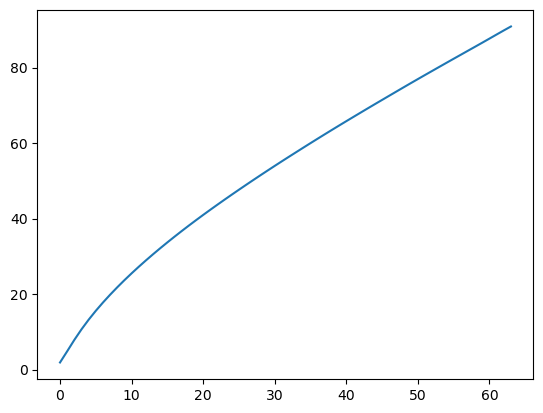

In [6]:
plt.plot(mean_sqs)

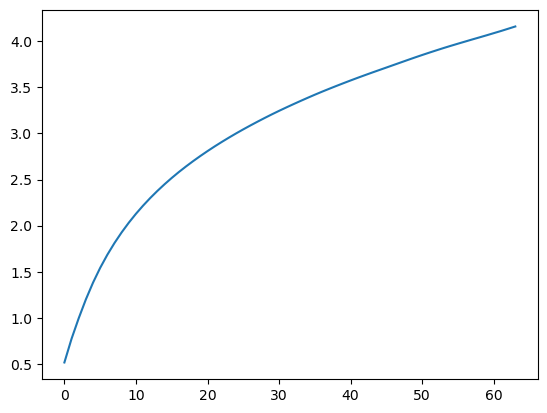

In [11]:
plt.plot((mean_sqs-means**2).sqrt())

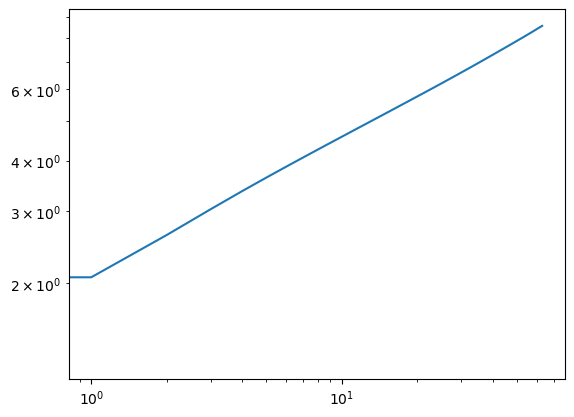

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(means)
ax.set_xscale('log')
ax.set_yscale('log')

In [43]:
from scipy.stats import linregress
def get_best_fit(vals,n_skip=10):

    x = torch.arange(1+n_skip,len(vals)+1).log10().numpy()
    y = vals[n_skip:].log10().numpy()

    result = linregress(x,y)
    m = result.slope
    b = result.intercept
    r_val = result.rvalue
    p_val = result.pvalue
    
    return m,b,r_val,p_val

    
    

In [48]:
m

0.35512211789298487

In [49]:
b

0.2903337652964074

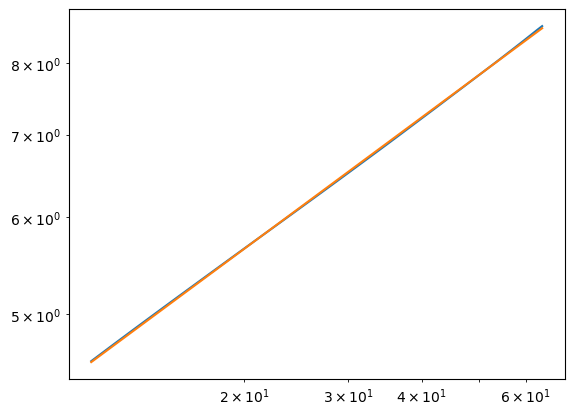

In [47]:
n_skip = 10
x = torch.arange(1+n_skip,len(means)+1)

m,b,*_ = get_best_fit(means,n_skip)

y2 = 10**(x.log10() * m + b)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x,means[n_skip:])
ax.plot(x,y2)
ax.set_xscale('log')
ax.set_yscale('log')

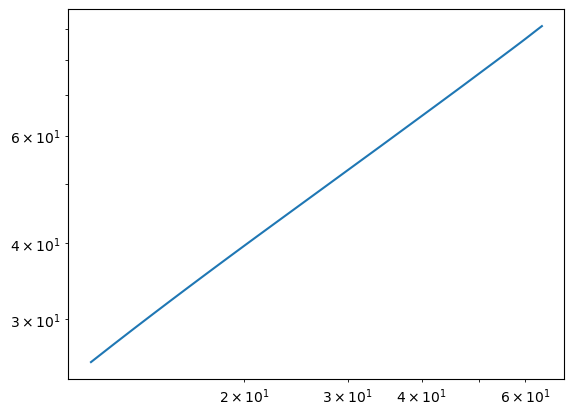

In [30]:
n_skip = 10
x = torch.arange(1+n_skip,len(means)+1)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x,mean_sqs[n_skip:])
ax.set_xscale('log')
ax.set_yscale('log')

In [21]:
means

tensor([1.2799, 2.0665, 2.6251, 3.0398, 3.3657, 3.6349, 3.8663, 4.0711, 4.2558,
        4.4246, 4.5806, 4.7264, 4.8632, 4.9926, 5.1156, 5.2328, 5.3450, 5.4530,
        5.5570, 5.6570, 5.7537, 5.8472, 5.9381, 6.0266, 6.1129, 6.1972, 6.2795,
        6.3601, 6.4389, 6.5163, 6.5920, 6.6664, 6.7392, 6.8109, 6.8815, 6.9511,
        7.0196, 7.0873, 7.1538, 7.2194, 7.2838, 7.3472, 7.4100, 7.4722, 7.5335,
        7.5937, 7.6531, 7.7120, 7.7701, 7.8274, 7.8839, 7.9400, 7.9953, 8.0503,
        8.1053, 8.1597, 8.2135, 8.2671, 8.3202, 8.3732, 8.4261, 8.4790, 8.5304,
        8.5800], dtype=torch.float64)